In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [2]:
import csv
import re 
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from matplotlib import pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from tensorflow.keras import metrics


from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

import random

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical


import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense


from scipy.sparse import csr_matrix

import tensorflow as tf


import warnings
warnings.filterwarnings('ignore')



from keras.layers import LSTM
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

import tensorflow.keras.metrics as metrics


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
train = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin-1')
test = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv", encoding='latin-1')

In [4]:
train.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


In [5]:
train.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [6]:
train = train.drop(columns = 'UserName')
train = train.drop(columns = 'ScreenName')
train = train.drop(columns = 'Location')
train = train.drop(columns = 'TweetAt')

In [7]:
test = test.drop(columns = 'UserName')
test = test.drop(columns = 'ScreenName')
test = test.drop(columns = 'Location')
test = test.drop(columns = 'TweetAt')

In [8]:
# Replace "Extremely Positive" with "Positive"
train['Sentiment'] = train['Sentiment'].replace('Extremely Positive', 'Positive')

# Replace "Extremely Negative" with "Negative"
train['Sentiment'] = train['Sentiment'].replace('Extremely Negative', 'Negative')

# Replace "Extremely Positive" with "Positive"
test['Sentiment'] = test['Sentiment'].replace('Extremely Positive', 'Positive')

# Replace "Extremely Negative" with "Negative"
test['Sentiment'] = test['Sentiment'].replace('Extremely Negative', 'Negative')

In [9]:
train['Sentiment'].value_counts()


Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64

In [10]:
train.shape, test.shape



((41157, 2), (3798, 2))

In [11]:
train0=train[train['Sentiment']=='Positive']
train1=train[train['Sentiment']=='Negative']
train2=train[train['Sentiment']=='Neutral']

In [12]:
train=pd.concat([train0,train1,train2],axis=0)


In [13]:
train.shape

(41157, 2)

# Pre-processing

In [14]:
#Remove Hashtags
train['OriginalTweet'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)

#Remove Mention
train['OriginalTweet'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)

#Remove URL
train['OriginalTweet'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)

train['OriginalTweet']=train['OriginalTweet'].str.lower()

#Remove Punctuations
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [15]:
#Remove Hashtags
test['OriginalTweet'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)

#Remove Mention
test['OriginalTweet'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)

#Remove URL
test['OriginalTweet'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)

test['OriginalTweet']=test['OriginalTweet'].str.lower()

#Remove Punctuations
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [16]:
stemmer = PorterStemmer()
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [17]:
stop = stopwords.words('english')
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [18]:
train = train.sample(frac=1, random_state=42)

In [19]:
train = train.reset_index(drop=True)


In [20]:
train.head(10)

,OriginalTweet,Sentiment
0,cdc boss downplay death estim still go groceri...,Negative
1,supermarket httpstcoo1kjpagcnv,Neutral
2,youâr welcom amid httpstcot3nzullqwn,Positive
3,thereâ direct correl shop onlin groceri stron...,Positive
4,know peopl opinion sun saw thi fb group thi sh...,Negative
5,whisper employe trader joeâ âyâal got ani g...,Negative
6,share profit low crude oil price peopl amid co...,Negative
7,know thi prepar power outag stock batteri flas...,Positive
8,mask may veri effect prevent wearer get sick p...,Negative
9,victoria help food product 1st time sinc wwii ...,Positive


In [21]:
X = train["OriginalTweet"]
y = train["Sentiment"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)



In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)


# Vectorization

In [24]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

In [25]:
model1 = Sequential()
model1.add(Embedding(input_dim=X_train_tfidf.shape[1], output_dim=128))  # Use a smaller embedding size
model1.add(LSTM(128))
model1.add(Dense(3, activation='sigmoid'))  # Assuming three sentiment classes (Negative, Neutral, Positive)

In [26]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


In [27]:
history1 = model1.fit(X_train_tfidf, y_train_encoded, epochs=10, batch_size=256, validation_data=(X_test_tfidf, y_test_encoded))

Epoch 1/10
129/129 [==============================] - 584s 4s/step - loss: 1.0465 - accuracy: 0.4357 - val_loss: 1.0375 - val_accuracy: 0.4450
Epoch 2/10
129/129 [==============================] - 575s 4s/step - loss: 1.0456 - accuracy: 0.4368 - val_loss: 1.0397 - val_accuracy: 0.4450
Epoch 3/10
129/129 [==============================] - 601s 5s/step - loss: 1.0455 - accuracy: 0.4368 - val_loss: 1.0385 - val_accuracy: 0.4450
Epoch 4/10
129/129 [==============================] - 607s 5s/step - loss: 1.0449 - accuracy: 0.4368 - val_loss: 1.0378 - val_accuracy: 0.4450
Epoch 5/10
129/129 [==============================] - 584s 5s/step - loss: 1.0450 - accuracy: 0.4368 - val_loss: 1.0380 - val_accuracy: 0.4450
Epoch 6/10
129/129 [==============================] - 584s 5s/step - loss: 1.0450 - accuracy: 0.4368 - val_loss: 1.0381 - val_accuracy: 0.4450
Epoch 7/10
129/129 [==============================] - 622s 5s/step - loss: 1.0448 - accuracy: 0.4368 - val_loss: 1.0377 - val_accuracy: 0.4450

In [28]:
loss, accuracy = model1.evaluate(X_test_tfidf, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

258/258 [==============================] - 112s 435ms/step - loss: 1.0377 - accuracy: 0.4450
Test Loss: 1.0377013683319092
Test Accuracy: 0.44497084617614746


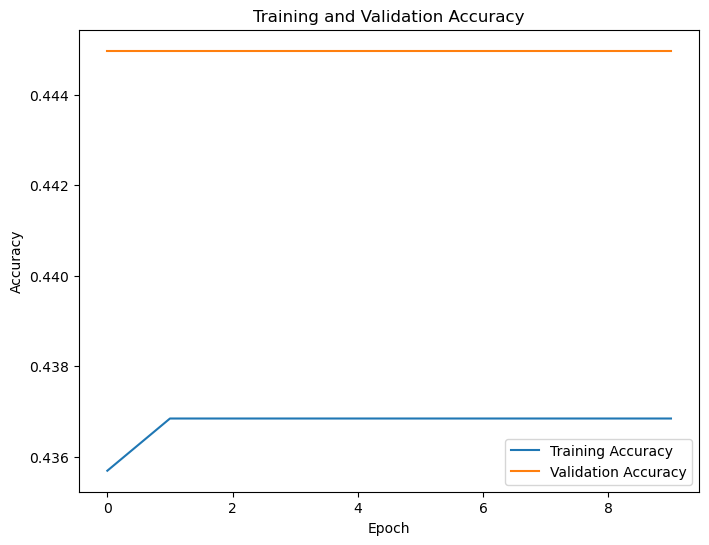

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

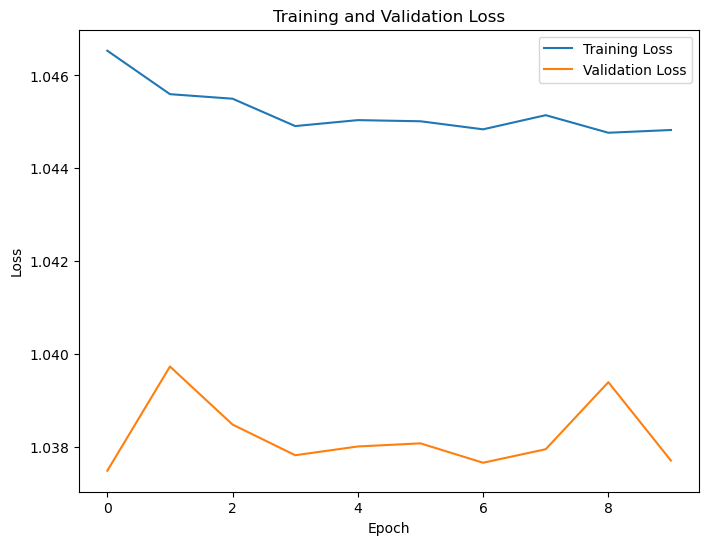

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()